In [148]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from modules import *
from sklearn.model_selection import train_test_split
import pickle
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage.transform import resize

In [149]:
def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

saved_model_path = './results_cifar10'
# saved_model_path = './results_MNIST'

exp = 'cifar10'
# exp = 'Olivetti'
# exp = 'MNIST'

# use same ResNet Encoder saved earlier!
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

epoch = 10


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device(1)   # use CPU or GPU

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(saved_model_path, 'model_epoch{}.pth'.format(epoch))))

print('ResNetVAE epoch {} model reloaded!'.format(epoch))

ResNetVAE epoch 10 model reloaded!


In [6]:
cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
    ]

In [158]:
resnet_vae.eval()

ResNet_VAE(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [10]:
x_reconst, z, mu, logvar = resnet_vae(torch.rand(1, 3, 224, 224).to(device))

## Test on CIFAR10 dataset

In [24]:
from torchvision import datasets
import torchvision.transforms as T
from wassdistance import SinkhornDistance

In [132]:
transform_rgb = T.Compose([T.Resize([244, 244]),
                T.ToTensor(),
                T.Normalize(mean=[0.0, 0.0, 0.0],
                            std=[1.0, 1.0, 1.0])])

transform_gray = T.Compose([T.Resize([64, 64]),
            T.ToTensor(),
            T.Lambda(lambda x: x.repeat(3, 1, 1)),
            # gray -> GRB 3 channel (lambda function)
            T.Normalize(mean=[0.0, 0.0, 0.0],
                        std=[1.0, 1.0, 1.0])])  # for grayscale images

In [154]:
cifar10_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_rgb)
cifar10_test = datasets.CIFAR10('./data', train= False, download=True, transform=transform_rgb)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
cifar100_train = datasets.CIFAR100('./data', train=True, download=True, transform=transform_rgb)
cifar100_test = datasets.CIFAR100('./data', train= False, download=True, transform=transform_rgb)

169001984it [01:19, 2130590.31it/s]                               


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [111]:
svhn_train = datasets.SVHN('./data/SVHN', split = 'train', download=True, transform=transform_rgb)
svhn_test = datasets.SVHN('./data/SVHN', split = 'test', download=True, transform=transform_rgb)

182041600it [01:19, 2295956.89it/s]                               


64275456it [00:31, 2012143.19it/s]                              


In [141]:
fmnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_gray)
fmnist_test = datasets.FashionMNIST('./data', train= False, download=True, transform=transform_gray)   

26422272it [00:07, 3498469.85it/s]                              


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



29696it [00:00, 156769.77it/s]                          


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



4422656it [00:03, 1278001.29it/s]                             


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



6144it [00:00, 553344.44it/s]           

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [134]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform_gray)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform_gray)

In [99]:
oxford_train = datasets.OxfordIIITPet('./data', split = 'trainval', target_types="category", download=True, transform = transform_rgb)      
oxford_test = datasets.OxfordIIITPet('./data', split = 'test', target_types="category", download=True, transform = transform_rgb)

In [155]:
def sensor_view_distribuiton_twins(sensor, train_dataset, device, sample_size):
    labels = set([x[1] for x in train_dataset])
    label_dist = {label: [] for label in labels}
    label_dist2 = {label: [] for label in labels}
    
    data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True)
    
    with torch.no_grad():
        if_samples = [0] * len(labels)
        for x, y in data_loader:
            # print(x.size()) # [1, 3, 64, 64]
            # x = 1 - x
            _, z_output, _, _ = sensor(x.to(device))
            label = int(y[0])
            
            if len(label_dist[label]) < sample_size:
                label_dist[label].append(z_output)
            elif len(label_dist[label]) == sample_size and len(label_dist2[label]) < sample_size:
                label_dist2[label].append(z_output)
                # print("dist2")
            else:
                if_samples[label] = 1

            if np.prod(if_samples):
                print("samples collected")
                return label_dist, label_dist2

In [159]:
cifar10_dist1, cifar10_dist2 = sensor_view_distribuiton_twins(resnet_vae, cifar10_train, device, 20)

samples collected


In [98]:
cifar100_dist1, cifar100_dist2 = sensor_view_distribuiton_twins(resnet_vae, cifar100_train, device, 80)

samples collected


In [105]:
oxford_dist1, oxford_dist2 = sensor_view_distribuiton_twins(resnet_vae, oxford_train, device, 20)

samples collected


In [116]:
svhn_dist1, svhn_dist2 = sensor_view_distribuiton_twins(resnet_vae, svhn_train, device, 100)

samples collected


In [185]:
mnist_dist1, mnist_dist2 = sensor_view_distribuiton_twins(resnet_vae, mnist_train, device, 100)

samples collected


In [176]:
fmnist_dist1, fmnist_dist2 = sensor_view_distribuiton_twins(resnet_vae, fmnist_train, device, 100)

samples collected


In [27]:
cifar10_dist1[0]

[tensor([[-4.7947e+00, -8.1193e+00, -1.8286e+00, -2.0845e+00, -5.0390e-01,
           2.1203e+00,  8.0512e+00,  4.7172e+00,  4.2206e+00, -2.9587e+00,
           1.3611e-01, -5.8959e+00,  3.2746e+00,  4.5655e+00,  6.6569e-01,
           3.5545e-01,  4.6391e+00,  5.0542e+00, -7.6602e+00,  1.9469e+00,
           6.5714e+00,  4.3532e+00,  5.4387e+00,  1.5123e-01,  3.3507e+00,
           4.0572e-01, -4.0082e+00, -4.1485e+00, -7.2675e-01,  1.9819e+00,
          -9.8756e+00, -2.3714e+00, -5.2949e+00, -1.8956e+00,  1.0039e+00,
          -3.6363e+00, -2.1305e+00,  3.9125e+00, -1.0624e+00, -4.0820e+00,
          -1.7379e-01, -1.2416e+00,  7.0924e+00, -5.7141e+00,  9.5266e-01,
           3.6146e+00, -3.9159e-01, -2.9878e+00, -8.3214e+00,  3.6814e-01,
           2.7717e+00,  2.0685e+00, -4.4311e+00,  2.3540e+00,  2.7981e+00,
           3.6331e+00, -3.6917e+00, -3.6268e+00, -7.1220e+00, -9.2414e-01,
           4.0090e+00,  2.7155e+00,  4.2671e+00,  4.6895e+00,  7.5928e+00,
           7.7761e+00,  3

In [120]:
def score(matrix):
    m = np.matrix(matrix)
    size = m.shape[0]
    trace = np.trace(m)
    score = (trace/size) / ((m.sum() - trace)/(size * (size -1)))
    return score

In [152]:
def wass_2_dists(dist1, dist2):
    sinkhorn = SinkhornDistance(eps=0.001, max_iter=500, device=device)
    d = len(dist1)
    matrix = []
    for i in range(d):
        print(i,"/",d-1)
        row = []
        for j in range(d):
            a_z = torch.cat(dist1[i])
            b_z = torch.cat(dist2[j])
            
            # a_z = torch.stack(emnist_clip_view[i])
            # b_z = torch.stack(emnist_clip_view2[j])
            wass, P, C = sinkhorn(a_z, b_z)
            # print(wass)
            row.append(wass.item())
        matrix.append(row)
    return matrix

In [153]:
def accu_rate(x):
    x = torch.Tensor(x)
    lowest = x.argmin(1)
    count = len(lowest)
    for i in range(len(lowest)):
        if i != lowest[i]:
            count -= 1
    rate = count/len(lowest)
    return lowest, rate

In [186]:
matrix = wass_2_dists(mnist_dist1, mnist_dist2)

0 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


In [187]:
matrix_s = score(matrix)
lowest, rate = accu_rate(matrix)

In [183]:
matrix_s


0.12081068870735782

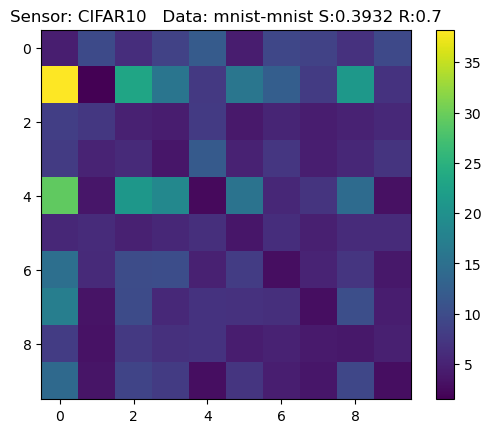

In [188]:
plt.imshow(matrix)
plt.title('Sensor: CIFAR10 '+ '  Data: ' +'mnist' + '-' + 'mnist' + ' S:' + str(round(matrix_s,4)) + ' R:' + str(round(rate,4)) )
plt.colorbar()

## Reconstruction 

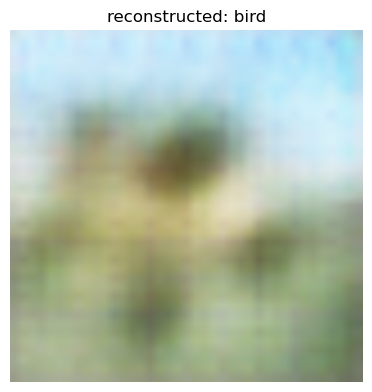

In [25]:
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
y_train = np.load(os.path.join(saved_model_path, 'y_{}_train_epoch{}.npy').format(exp, epoch))

ind = 1001
zz = torch.from_numpy(z_train[ind]).view(1, -1)
# X = np.transpose(y_train[ind], (1, 2, 0))

new_imgs = decoder(resnet_vae, device, zz)

fig = plt.figure(figsize=(10, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(X)
# plt.title('original')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_imgs)
plt.title('reconstructed: ' + str(cifar10_labels[y_train[ind]]))
plt.axis('off')
plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

## Generate new images from latent points

In [20]:
# choose two original images
sample1, sample2 = 0, 1
w = 0.4 # weight for fusing two images

X1 = np.transpose(X_train[-sample1], (1, 2, 0))
X2 = np.transpose(X_train[-sample2], (1, 2, 0))

# generate image using decoder
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(X1)
plt.title('original 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X2)
plt.title('original 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()



NameError: name 'X_train' is not defined